In [2]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(ggbiplot)
library(factoextra)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(GOSemSim)
library(tibble)
library(tidytext)
library(dplyr)
library(wordcloud2)
library(devtools)
library(GO.db)
library(ggwordcloud)
library(tidyverse)
library(cluster)
library(factoextra)
library(dynamicTreeCut)
library(CrossClustering)
library(corrplot)
library(dendsort)
library(ggdendro)

library(dynamicTreeCut)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [4]:
citation("topGO")


To cite package ‘topGO’ in publications use:

  Adrian Alexa and Jorg Rahnenfuhrer (2019). topGO: Enrichment Analysis
  for Gene Ontology. R package version 2.38.1.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {topGO: Enrichment Analysis for Gene Ontology},
    author = {Adrian Alexa and Jorg Rahnenfuhrer},
    year = {2019},
    note = {R package version 2.38.1},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.


In [9]:
setwd("~/ownCloud/Meng/")

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC_H <- color_ND
color_CHC_M <- "#FFCC00"
color_CHC_L <- "#FF3300"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3


## Define color of cells
## Define color of cells
## Define color of cells
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
Neurons = "#ADDD8E"
Oligodendrocytes = "#DD3497"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [3]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_PC1_for_stage <- function(protein_intens, braak){
    intens <- NULL
    for(i in sort(unique(braak))){
        intens <- cbind(intens, 
                    prcomp(protein_intens[, which(braak == i)], center = TRUE, scale = TRUE)$x[,1])
    }
    return(intens)
}

cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}


remove_multipleName_protein <- function(proteins){
    proteins[grep(";", proteins)] <- NA
    return(proteins)
}

get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

In [4]:
CountFrequency_words <- function(functional_clusters){
    # Read the description of all GO:BP -- this will be the background to remove redundant words
    # You will need this file: i'll send by email
    all_go_bp <- fread("Public_database/go_terms_BP_all.txt", h=F, stringsAsFactors = F, sep="\t")
    
    # Create a list: each element of the list is a cluster

    all_dset <- list()
    all_dset[[1]] <- all_go_bp$V1
    
    for(i in sort(unique(functional_clusters$cluster))){
        all_dset[[i+1]] <- functional_clusters$term_name[which(functional_clusters$cluster == i)]
    }
    
    
    # Define output
    word_frequency_dset <- list()
    
    # Main loop to calculate word frequency
    for (i in 1:length(all_dset)){
      # Convert to dataframe and make sure there are characters only
      text <- data.frame(text=all_dset[[i]])
      text$text <- as.character(text$text)
      
      # Covert dataframe to tibble
      text_df <- tibble(line = 1:nrow(text), text = text)
      text_df <- mutate(text_df, text = text$text)
      
      # Count word occurrence
      x <- text_df %>% unnest_tokens(word, text) %>%    # split words
        anti_join(stop_words) %>%    # take out "a", "an", "the", etc.
        count(word, sort = TRUE)    # count occurrences
      
      # Convert back to dataframe
      x <- as.data.frame(x)
      colnames(x) <- c("word", "freq")
      
      # Assign to output
      word_frequency_dset[[i]] <- x
    }
    
    # Extract background and calculate % and take top 2.5%
    bkg <- word_frequency_dset[[1]]
    bkg$perc <- bkg$freq/nrow(all_go_bp)
    top_5_pc <- bkg[which(bkg$perc >= 0.025),]
    
    # Now exclude these frequent words from the clusters names
    for (i in 2:length(word_frequency_dset)){
      sb <- word_frequency_dset[[i]]
      sb <- sb[which(!(sb$word %in% top_5_pc$word)),]
      word_frequency_dset[[i]] <- sb
    }
    
    # Try some plot -- seems like it is not possible to plot multiple plots in one
    #wordcloud2(data = word_frequency_dset[[2]])
    #wordcloud2(data = word_frequency_dset[[3]])
    #wordcloud2(data = word_frequency_dset[[4]])
    #wordcloud2(data = word_frequency_dset[[5]])
    
    return(word_frequency_dset)
}

In [158]:
GOterm_query_test_table <- function(protein_list, gene_list, ontology, algorithm = "classic", statistic = "fisher", 
                         annot = annFUN.gene2GO, gene2GO = geneSymbol2go_list){
    
    GOdata <- new("topGOdata",
                  ontology = ontology,
                  allGenes=gene_list,
                  annot=annot, 
                  gene2GO=gene2GO,
                  nodeSize=5
                 )
    
    allGO =usedGO(object = GOdata)
    
    result <- runTest(GOdata, 
                      algorithm = algorithm,
                      statistic = statistic)
    
    allRes <- as.data.frame(GenTable(GOdata, Fisher = result, ranksOf = "Fisher", 
                                     topNodes = length(allGO), numChar = 1000), stringsAsFactors = FALSE)
    
    allRes$Fisher <- as.numeric(allRes$Fisher)
    if(length(which(is.na(allRes$Fisher))) > 0)
        allRes[is.na(allRes$Fisher), ]$Fisher <- 1.0e-31
    
    allRes <- subset(allRes, Annotated < 100)
                      
    FDR <- p.adjust(p = as.numeric(allRes[,"Fisher"]), method="BH")
    allRes <- cbind(allRes, FDR)
    
    sig_Res <- subset(allRes, FDR <= 0.05)
    
    if(nrow(sig_Res) == 0)
        return("Can not find significant GO pathway in this cluster!")
    
    allGO = genesInTerm(GOdata)
    sig_GO <- allGO[names(allGO) %in% sig_Res$GO.ID]
    sig_GO_protein <- lapply(sig_GO, function(x) x[x %in% protein_list])
    sig_Res$proteins <- NA

    for(i in 1:nrow(sig_Res)){
        sig_Res[i, ]$proteins <- paste(unlist(sig_GO_protein[sig_Res[i, ]$GO.ID]), collapse = ', ')
    }
    
    return(sig_Res)
}

In [10]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

dim(High_quality_protein_intensity_matrix)

backgroud_protein_list <- unique(get_first_protein(High_quality_protein_intensity_matrix$protein))

length(backgroud_protein_list)

geneSymbol2go <- fread('awk \'{print $3 "," $4}\' R_workstation/100_plus_proteomic_data_Analysis/goa_human.gaf | grep "GO:"', header=FALSE, sep=",")
geneSymbol2go_list <- by(geneSymbol2go$V2, geneSymbol2go$V1, function(x) as.character(x))

go2geneSymbol_list <- by(geneSymbol2go$V1, geneSymbol2go$V2, function(x) as.character(x))

[1] 3448  191

[1] 3102

In [11]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [12]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

In [13]:
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [14]:
celltype <- cell_type_matrix[which(cell_type_matrix$protein %in% High_quality_protein_intensity_matrix$protein), ]

In [162]:
celltype

,protein,genesymbol,HUGO_gene,celltype
,<chr>,<chr>,<chr>,<chr>
1,SLC12A2,SLC12A2,SLC12A2,Oligodendrocytes
2,CASKIN1,CASKIN1,CASKIN1,NA
3,GNG2,GNG2,GNG2,NA
4,CARNS1,CARNS1,CARNS1,Oligodendrocytes
5,FH,FH,FH,NA
6,EFHD2,EFHD2,EFHD2,NA
7,PCLO,PCLO,PCLO,NA
8,HSPA1A;HSPA1B,HSPA1A,HSPA1A,NA
9,STIP1,STIP1,STIP1,NA


In [15]:
protein_info <- data.frame(protein = High_quality_protein_intensity_matrix$protein,
                           genes = get_first_protein(High_quality_protein_intensity_matrix$protein))

In [16]:
protein_info <- data.frame(protein_info, celltype = celltype$celltype)

In [17]:
protein_info$HUGO_gene <- celltype$HUGO_gene

In [18]:
table(protein_info$celltype)


      Astrocytes      Endothelial        ExNeurons        InNeurons 
              68                6               77               23 
       Microglia              OPC Oligodendrocytes          Unknown 
              34               18               75               13 

In [19]:
protein_info

protein,genes,celltype,HUGO_gene
<fct>,<fct>,<fct>,<chr>
SLC12A2,SLC12A2,Oligodendrocytes,SLC12A2
CASKIN1,CASKIN1,NA,CASKIN1
GNG2,GNG2,NA,GNG2
CARNS1,CARNS1,Oligodendrocytes,CARNS1
FH,FH,NA,FH
EFHD2,EFHD2,NA,EFHD2
PCLO,PCLO,NA,PCLO
HSPA1A;HSPA1B,HSPA1A,NA,HSPA1A
STIP1,STIP1,NA,STIP1


In [20]:
setwd("~/ownCloud/Meng/")

In [21]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [22]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

#metadata <- read_excel("100_plus_project/Metadata/2019_07_23_Proteomics_Metadata_forMeng_v3.xlsx",
#                       sheet=1,col_names=TRUE, na="NA")
#metadata <- as.data.frame(metadata)
#colnames(metadata)

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which(metadata$apoe %in% c(22)),]$apoe_OR <- 0.24
metadata[which(metadata$apoe %in% c(23, 32)),]$apoe_OR <- 0.5
metadata[which(metadata$apoe %in% c(33)),]$apoe_OR <- 1.0
metadata[which(metadata$apoe %in% c(24, 42)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe %in% c(34, 43)),]$apoe_OR <- 5.5
metadata[which(metadata$apoe %in% c(44)),]$apoe_OR <- 20.6

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)

[1] 3448  191

In [23]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [24]:
protein <- High_quality_protein_intensity_matrix$protein

In [25]:
#protein_intensity_combat <- cbind(protein, protein_intensity_combat)

In [26]:
#protein_intensity_combat

In [27]:
write.table(protein_intensity_combat, 
                file = "100_plus_results/protein_intensity_combat.tsv", 
                col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")

In [28]:
#################Differentially expressed proteins analysis###############

In [29]:
Braak_test_index <- which((metadata$GROUP != "CHC"))
length(Braak_test_index)

protein_intensity_combat_nonlog <- 2^protein_intensity_combat

[1] 141

In [30]:
pathology_related_proteins_ANOVA <- as.data.frame(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                        cal_ANOVA_test, metadata[Braak_test_index, ]$fBraak))
colnames(pathology_related_proteins_ANOVA) <- c("p_value")
pathology_related_proteins_ANOVA$adjusted_p_value <- p.adjust(pathology_related_proteins_ANOVA$p_value,
                                                              method="BH")

pathology_related_proteins_ANOVA$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
#pathology_related_proteins_ANOVA$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)


pathology_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                       lm_sig_test, metadata[Braak_test_index,]$fBraak)))
colnames(pathology_related_proteins_lm) <- c("effect_size", "p_value")
pathology_related_proteins_lm$adjusted_p_value <- p.adjust(pathology_related_proteins_lm$p_value, 
                                                              method="BH")

#pathology_related_proteins_lm$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
#                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
#pathology_related_proteins_lm$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)

In [31]:
sum(pathology_related_proteins_ANOVA$effect_size < 0)
sum(pathology_related_proteins_ANOVA$effect_size > 0)

[1] 1832

[1] 1616

In [32]:
sum(pathology_related_proteins_lm$effect_size < 0)
sum(pathology_related_proteins_lm$effect_size > 0)

[1] 1809

[1] 1639

In [33]:
top_percent_p <- 0.05
top_percent_lfc <- 0.05

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)
top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]
top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)
top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]
top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)
top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]
top_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(top_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)
top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]
top_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(top_up_lm)

[1] 13

[1] 28

[1] 30

[1] 37

In [34]:
topT_down_union <- union(top_down_ANOVA, top_down_lm)
topT_up_union <- union(top_up_ANOVA, top_up_lm)
length(topT_down_union)
length(topT_up_union)

topT_sig_index <- c(topT_down_union,topT_up_union)
length(topT_sig_index)

[1] 30

[1] 40

[1] 70

In [35]:
top_percent_p <- 0.20
top_percent_lfc <- 0.20

## Top down-regulating proteins ##
## Top down-regulating proteins ##

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)

top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]

top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)

top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]

top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)

#plot_selected_protein_lfc(pathology_related_proteins_ANOVA, c(top_up_ANOVA, top_down_ANOVA))

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)

top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]

top_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(top_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)

top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]

top_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(top_up_lm)

#plot_selected_protein_es(pathology_related_proteins_lm, c(top_down_lm, top_up_lm))

[1] 140

[1] 190

[1] 206

[1] 235

In [36]:
top_down_union <- union(top_down_ANOVA, top_down_lm)
top_up_union <- union(top_up_ANOVA, top_up_lm)
length(top_down_union)
length(top_up_union)

sig_index <- c(top_down_union,top_up_union)
length(sig_index)

[1] 226

[1] 246

[1] 472

In [201]:
Braak_test_index <- which((metadata$GROUP != "CHC") & (metadata$age<100))

In [202]:
order_fBraak_index <- order(metadata[Braak_test_index, ]$fBraak)
protein_intens_Braak_order <- protein_intensity_combat[sig_index, ][, Braak_test_index[order_fBraak_index]]

In [203]:
#protein_intens_Braak_order <- scale(protein_intens_Braak_order)

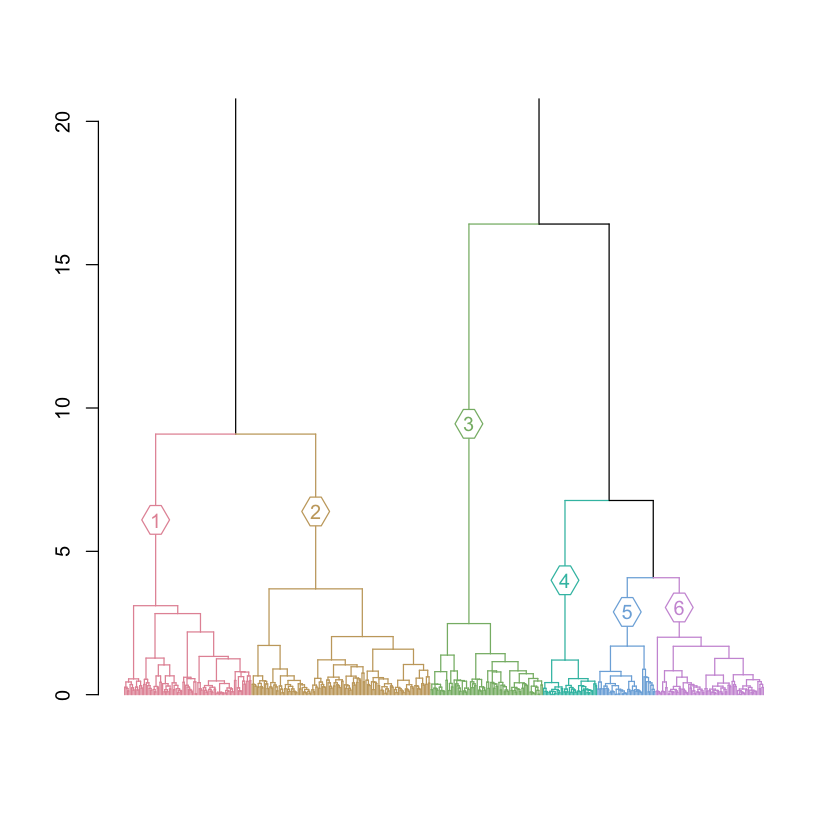

In [204]:
hc <- hclust(amap:::Dist(protein_intens_Braak_order, 
                         method = "correlation"), method = "ward.D")
c_group <- 6 # number of clusters
dend1 <- as.dendrogram(hc)

#protein_clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = TRUE)
clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)
#clust <- dynamicTreeCut:::cutreeDynamic(hc, distM = distMa, method = "tree")
#c_group <- max(clust) 

orig_label <- labels(dend1)

plot_labels <- clust

lbls <- unique(clust)
labels(dend1) <- plot_labels

dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

# get the color of the leaves (labels) for `heatmap.2`
col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]

plot_labels <- plot_labels[order(order.dendrogram(dend1))]

dend1 <- set(dend1, "labels_cex", 0.8)

#pdf("Temp_results/protein_clustering_dendrogram.pdf")
#par(mar=c(1, 3, 1, 1))
plot(dend1, ylim = c(0, 20), leaflab = "none") # use side = T to horiz mirror if needed
#dev.off()

In [205]:
#distMa <- amap:::Dist(protein_intens_Braak_order, 
#                         method = "correlation") %>% as.matrix()
#
#distMa
#
#hc <- hclust(amap:::Dist(protein_intens_Braak_order, 
#                         method = "correlation"), method = "ward.D")
#
#table(dynamicTreeCut:::cutreeDynamic(hc, distM = distMa, method = "tree"))

In [206]:
map_cluster_to_protein <- function(clust, proteins){
    new_cluster <- as.numeric(lapply(proteins, function(x){return(clust[which(names(clust) == x)])}))
    return(data.frame(protein = proteins,
                      clust = new_cluster))
}

In [207]:
protein_clust <- map_cluster_to_protein(clust, rownames(protein_intensity_combat[sig_index, ]))

In [208]:
protein_clust

protein,clust
<fct>,<dbl>
SYT12,2
RPH3A,2
VGF,2
NDUFS3,1
PDK3,1
NDUFA12,1
OLFM1,2
SLC25A11,1
ACTN2;ACTN3,2


In [216]:
protein_clust$gene <- protein_info[sig_index, ]$genes
protein_clust$HUGO_gene <- protein_info[sig_index, ]$HUGO_gene
protein_clust$celltype <- protein_info[sig_index, ]$celltype

In [217]:
table(protein_clust$clust)


  1   2   3   4   5   6 
 94 132  83  40  43  80 

In [218]:
protein_clust

protein,clust,gene,HUGO_gene,celltype
<fct>,<dbl>,<fct>,<chr>,<fct>
SYT12,2,SYT12,SYT12,NA
RPH3A,2,RPH3A,RPH3A,NA
VGF,2,VGF,VGF,InNeurons
NDUFS3,1,NDUFS3,NDUFS3,NA
PDK3,1,PDK3,PDK3,NA
NDUFA12,1,NDUFA12,NDUFA12,NA
OLFM1,2,OLFM1,OLFM1,NA
SLC25A11,1,SLC25A11,SLC25A11,NA
ACTN2;ACTN3,2,ACTN2,ACTN2,NA


In [219]:
save(protein_clust, file = "Temp_results/protein_clust.Rdata")

In [178]:
for(i in 1:c_group){
    
    protein_list <- as.character(unique(subset(protein_clust, clust == i)$gene))
    
    cat("this is cluster", i, end = "\n")
    print(length(protein_list))
    
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
        names(geneList) <- backgroud_protein_list
    
    sigGOID <- NULL
    
    sigRes_BP <- GOterm_query_test_table(protein_list, geneList, "BP")
    print(sigRes_BP)
        
    #sigRes_MF <- GOterm_query_test_table(protein_list, geneList, "MF")
    #print(sigRes_MF)
    #    
    #sigRes_CC <- GOterm_query_test_table(protein_list, geneList, "CC")
    #print(sigRes_CC)
    
    #sigRes_BP <- GOterm_query_test_table(protein_list, geneList, "BP")
    #if(class(sigRes_BP) == 'character')
    #    print(sigRes_BP)
    #else{
    #    sigGOID <- rbind(sigGOID, sigRes_BP[, c("GO.ID", "Fisher")])
    #    write.table(sigRes_BP, 
    #                file = paste("100_plus_results/GOterm_6cluster_5_100_move_syserror/1_GOterm_BP_for_Cluster_", i, 
    #                             ".txt", sep = ""),
    #                row.names = FALSE, quote = FALSE, sep = "\t")
    #}
    #    
    #sigRes_MF <- GOterm_query_test_table(protein_list, geneList, "MF")
    #if(class(sigRes_MF) == 'character')
    #    print(sigRes_MF)
    #else{
    #    sigGOID <- rbind(sigGOID, sigRes_MF[, c("GO.ID", "Fisher")])
    #    write.table(sigRes_MF, 
    #                file = paste("100_plus_results/GOterm_6cluster_5_100_move_syserror/1_GOterm_MF_for_Cluster_", i, 
    #                             ".txt", sep = ""),
    #                row.names = FALSE, quote = FALSE, sep = "\t")
    #}
    #    
    #sigRes_CC <- GOterm_query_test_table(protein_list, geneList, "CC")
    #if(class(sigRes_CC) == 'character')
    #    print(sigRes_CC)
    #else{
    #     sigGOID <- rbind(sigGOID, sigRes_CC[, c("GO.ID", "Fisher")])
    #    write.table(sigRes_CC, 
    #                file = paste("100_plus_results/GOterm_6cluster_5_100_move_syserror/1_GOterm_CC_for_Cluster_", i, 
    #                             ".txt", sep = ""),
    #                row.names = FALSE, quote = FALSE, sep = "\t")
    #}
    #
    #write.table(sigGOID, 
    #            file = paste("100_plus_results/GOterm_6cluster_5_100_move_syserror/1_GOterm_ID_for_Cluster_", i, 
    #                         ".txt", sep = ""),
    #            row.names = FALSE, quote = FALSE, sep = "\t")


}

this is cluster 1 
[1] 98



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2158 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                                     Term
7  GO:2000310                     regulation of NMDA receptor activity
8  GO:0060078            regulation of postsynaptic membrane potential
9  GO:0035235          ionotropic glutamate receptor signaling pathway
10 GO:1900449       regulation of glutamate receptor signaling pathway
12 GO:0099601         regulation of neurotransmitter receptor activity
13 GO:0050806             positive regulation of synaptic transmission
14 GO:0048167                        regulation of synaptic plasticity
16 GO:0007215                     glutamate receptor signaling pathway
19 GO:0010469                regulation of signaling receptor activity
20 GO:0099565             chemical synaptic transmission, postsynaptic
24 GO:0048489                               synaptic vesicle transport
25 GO:0097480           establishment of synaptic vesicle localization
27 GO:2001257                    regulation of cation channel activity
30 GO:


Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1723 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                                     Term
1  GO:0042773                 ATP synthesis coupled electron transport
2  GO:0042775   mitochondrial ATP synthesis coupled electron transport
3  GO:0006119                                oxidative phosphorylation
4  GO:0010257                      NADH dehydrogenase complex assembly
5  GO:0032981       mitochondrial respiratory chain complex I assembly
6  GO:0006120     mitochondrial electron transport, NADH to ubiquinone
7  GO:0022904                     respiratory electron transport chain
8  GO:0033108         mitochondrial respiratory chain complex assembly
40 GO:0009060                                      aerobic respiration
41 GO:1902600                           proton transmembrane transport
48 GO:0006123 mitochondrial electron transport, cytochrome c to oxygen
49 GO:0019646                         aerobic electron transport chain
54 GO:1990542                    mitochondrial transmembrane transport
   Ann


Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2384 nontrivial nodes
		 parameters: 
			 test statistic: fisher


       GO.ID                                 Term Annotated Significant
1 GO:0030855      epithelial cell differentiation        92          11
2 GO:0030198    extracellular matrix organization        61           9
4 GO:0043062 extracellular structure organization        72           9
5 GO:0007229  integrin-mediated signaling pathway        27           6
  Expected  Fisher        FDR
1     1.94 2.1e-06 0.00672375
2     1.28 3.3e-06 0.00672375
4     1.52 1.4e-05 0.01426250
5     0.57 1.4e-05 0.01426250
                                                                 proteins
1 AKR1C1, ANXA1, ANXA4, CLIC4, CNN3, FLNA, ICAM1, IQGAP1, TJP2, TPP1, VIM
2               APP, CD44, HTRA1, ICAM1, ITGA7, ITGB1, ITGB4, PRDX4, VCAN
4               APP, CD44, HTRA1, ICAM1, ITGA7, ITGB1, ITGB4, PRDX4, VCAN
5                                  FLNA, ITGA7, ITGB1, ITGB4, LIMS1, TLN1
this is cluster 4 
[1] 38



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1461 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
this is cluster 5 
[1] 48



Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1622 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                                          Term
2  GO:0016054                                organic acid catabolic process
3  GO:0046395                             carboxylic acid catabolic process
4  GO:1902946                        protein localization to early endosome
5  GO:1902965          regulation of protein localization to early endosome
6  GO:1902966 positive regulation of protein localization to early endosome
7  GO:1905666                regulation of protein localization to endosome
8  GO:1905668       positive regulation of protein localization to endosome
9  GO:0046365                              monosaccharide catabolic process
10 GO:0006000                                    fructose metabolic process
   Annotated Significant Expected  Fisher        FDR
2         94           9     1.50 1.2e-05 0.02153929
3         94           9     1.50 1.2e-05 0.02153929
4          5           3     0.08 3.7e-05 0.02153929
5          5           3    


Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1325 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                              Term Annotated
2  GO:0072525 pyridine-containing compound biosynthetic process        46
3  GO:0072524    pyridine-containing compound metabolic process        72
4  GO:0019674                             NAD metabolic process        29
5  GO:0006735                                 NADH regeneration        16
6  GO:0061621                              canonical glycolysis        16
7  GO:0061718             glucose catabolic process to pyruvate        16
9  GO:0061620    glycolytic process through glucose-6-phosphate        17
10 GO:0006007                         glucose catabolic process        18
11 GO:0061615   glycolytic process through fructose-6-phosphate        18
12 GO:0009108                     coenzyme biosynthetic process        94
13 GO:0009435                          NAD biosynthetic process        19
15 GO:0019359      nicotinamide nucleotide biosynthetic process        43
16 GO:0019363          pyridine nucleo


Building most specific GOs .....
	( 6506 GO terms found. )

Build GO DAG topology ..........
	( 10549 GO terms and 24620 relations. )

Annotating nodes ...............
	( 2945 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1824 nontrivial nodes
		 parameters: 
			 test statistic: fisher


        GO.ID                                                      Term
1  GO:0098754                                            detoxification
2  GO:1990748                                   cellular detoxification
8  GO:0098869                           cellular oxidant detoxification
9  GO:0017001                              antibiotic catabolic process
10 GO:0006081                       cellular aldehyde metabolic process
11 GO:0097237                      cellular response to toxic substance
12 GO:0051187                                cofactor catabolic process
15 GO:0016999                              antibiotic metabolic process
18 GO:0072524            pyridine-containing compound metabolic process
19 GO:0046364                       monosaccharide biosynthetic process
22 GO:0033559                  unsaturated fatty acid metabolic process
23 GO:0046434                         organophosphate catabolic process
24 GO:0006801                              superoxide metabolic 